## About Dataset: 

### Data Description: 


- Data is:
##### Customer Type:
- A. Customers IDs. 
- B. Avg_Credit_Limit: Various customers of a bank with their credit limit, 
- C. Total_Credit_Cards: The total number of credit cards the customer has,
##### Different channels through which customer has contacted the bank for any queries:
- D. Total_visits_bank
- E. Total_visits_online
- F. Total_calls_made


### Goal: 

1. Data Analysis
2. How many clusters are formed ?
3. Identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.
3. How are these segments different from each other?
4. What are your recommendations to the bank on how to better market to and service these customers?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
df.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


In [4]:
# Checking data type, count, missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


### Fixing Dataset

In [5]:
#Rename Customer Key
df = df.rename({"Customer Key":"Customer_Key"}, axis='columns')

In [6]:
# Transform Customer Key as Category
df.Customer_Key = df.Customer_Key.astype('category')

In [7]:
# Checking unique values
df.nunique()

Sl_No                  660
Customer_Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [8]:
# Checking missing Values
df.isna().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Comments: 
- No missing values,
- We can drop the columns Sl_No.

In [9]:
#Dropping columns that are not important
df.drop('Sl_No',axis=1,inplace=True)

In [10]:
# Checking summary
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer_Key,660.0,655.0,96929.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg_Credit_Limit,660.0,NaN,NaN,NaN,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,NaN,NaN,NaN,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,NaN,NaN,NaN,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,NaN,NaN,NaN,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,NaN,NaN,NaN,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [11]:
df2=df.copy() #Copying original data to use in different Clusters

In [12]:
df3=df.copy() #Copying original data to use in different Clusters

### Comments
- There is a diversification on Credit Limit: Balancing between Min of 3,000.00 and Max of 200,000.00
- Customers holds an average of 4 credit cards, almost 5.
- Bank Visits is not so low, with average of ~3 visits by customer
- Online Visits is showing almost the same average as Bank Visit with average of 2.6, however we can observe Max of 15 visits. 
- Call made is high in average than Online Visits, with 3.5 calls. 

## EDA - Univariate Analysis

In [13]:
#  Function for Univariate Analysis using Histogram_Boxplot. (Also identify outliears)
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.15, .50)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='blue') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

In [14]:
# Function to create barplots of each column individualy

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

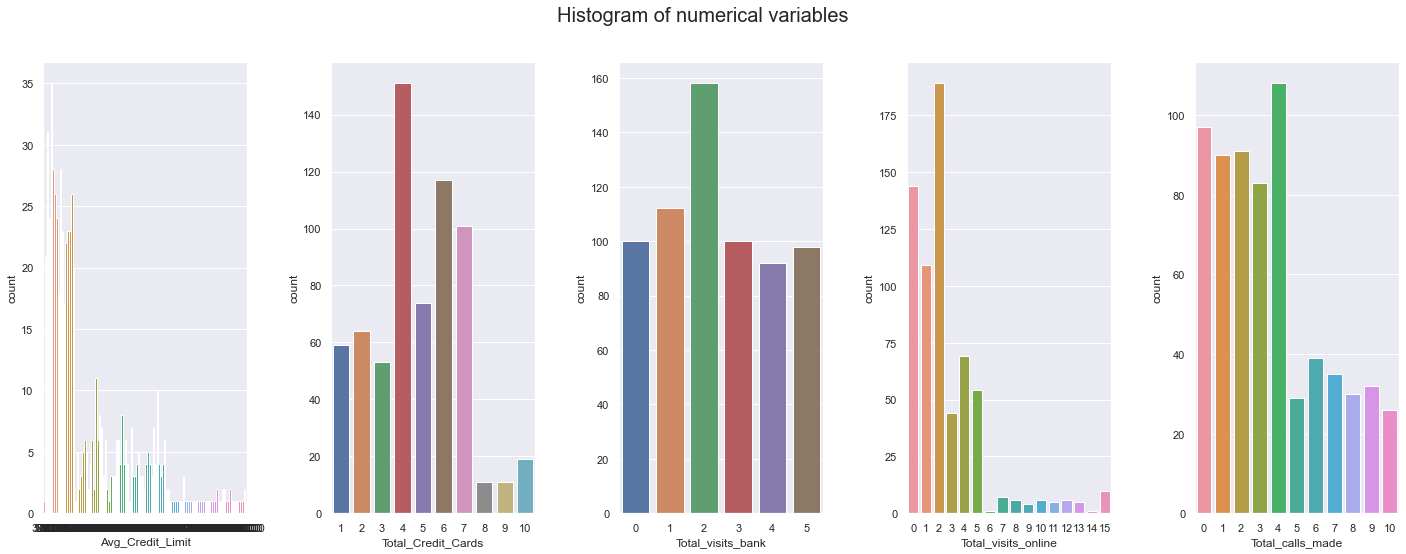

In [15]:
# Function to create bar plot all columns
all_col = df.iloc[:,1:].columns.tolist()
fig, axes = plt.subplots(1, 5,  figsize=(20, 8))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.countplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

## Comments
- On this chart we can confirm the observations made above. Most of the customer holds 4 Credit Card, and to go to the bank is not so commom if compared with Online visits.The frequency of phone calls and online access is greater than the physical trip to the bank 

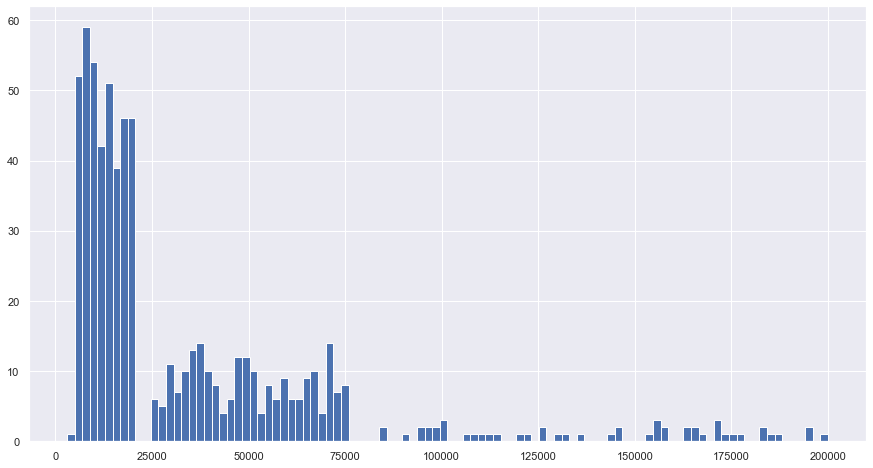

In [16]:
Av_Cred = (df["Avg_Credit_Limit"]) #Including only Avg_Credit_Limit Column
df["Avg_Credit_Limit"].hist( bins=100, figsize=(15,8)); 

### Comments
1. About: Average Credit Card Limit
- Average Credit Card Limit concentrates in the range 3,000.00 to 78,000.00. However we can see significant outliers. 
- Most of the customer didnt get 25,000.00 limit

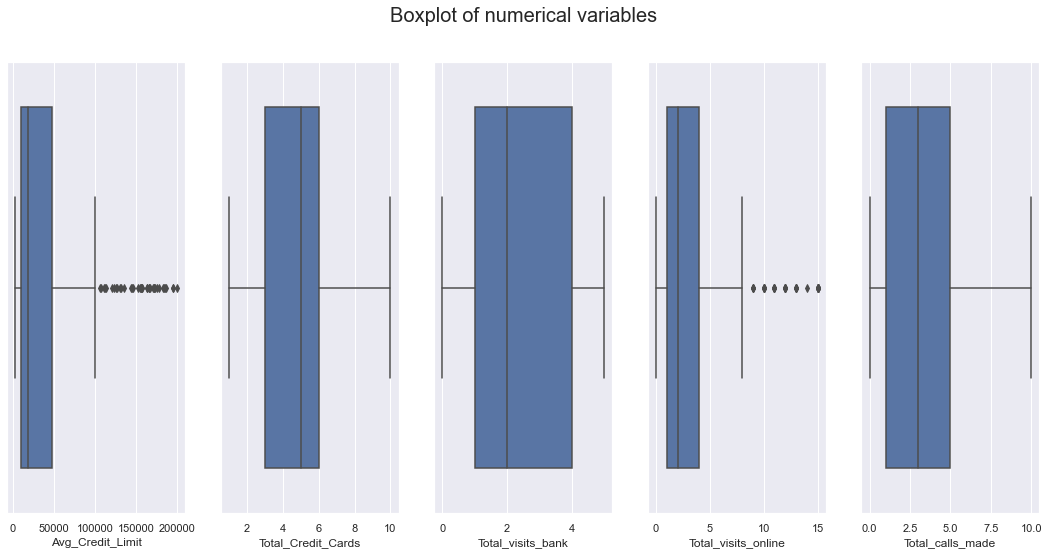

In [17]:
fig, axes = plt.subplots(1, 5,  figsize=(15, 8))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

### Comments 
- As expected Visits Banks shows very consistent behavior. 
- Credit Limit and Visits online are showing outliers.

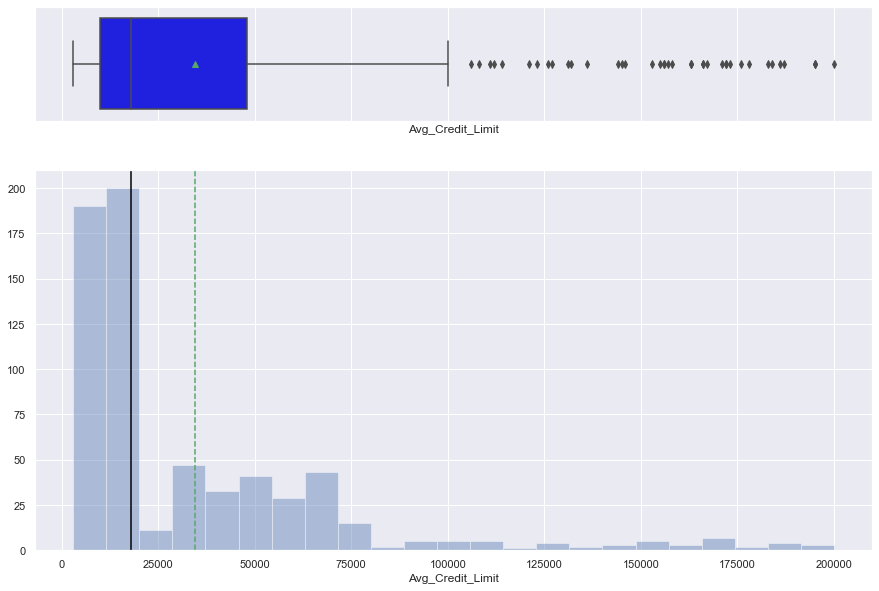

In [18]:
histogram_boxplot(df.Avg_Credit_Limit)

### Comments
1. About: Average Credit Card Limit
- Here we can see better the significant right skewed. 
- The distribution of Average Credit card Limite is right-skewed.

## Making pairplot

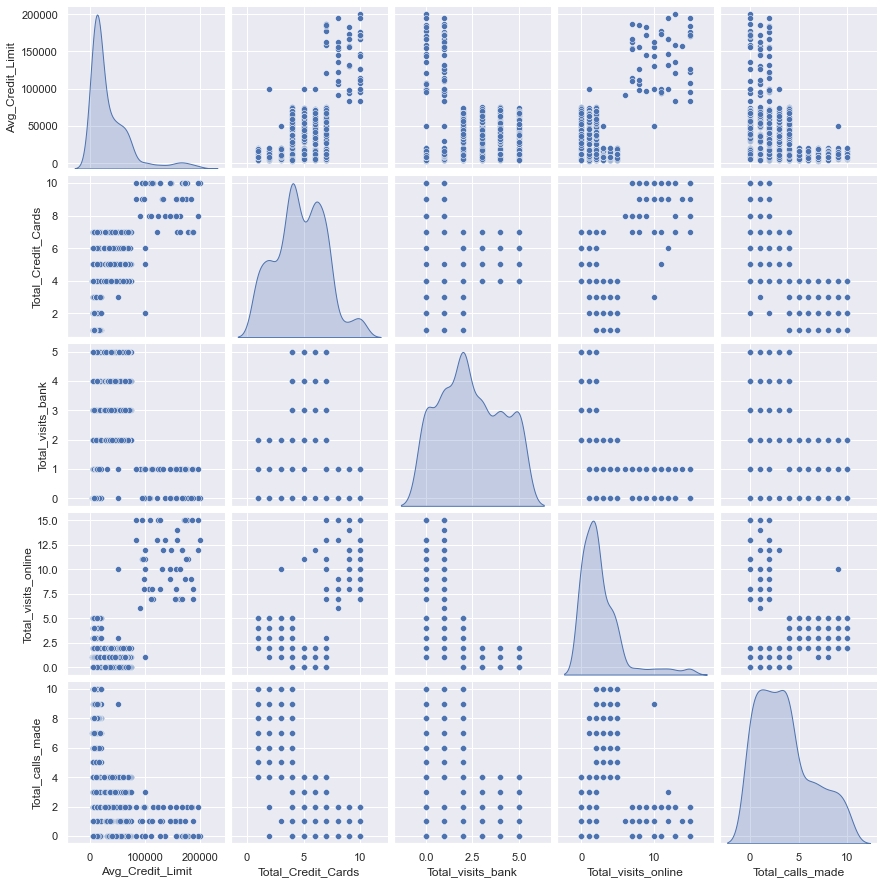

In [19]:
sns.pairplot(df[all_col],diag_kind="kde")

### Comments
- Total Credit Card, Total Visits Bank and Total Calls Made seems to be multimodal distributed. 
- Total Visits Online seems to be bimodal distributed.


## Bivariate Analsysis

In [20]:
# This is correlation in graphical representation
def plot_corr(df, size=12):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap='coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

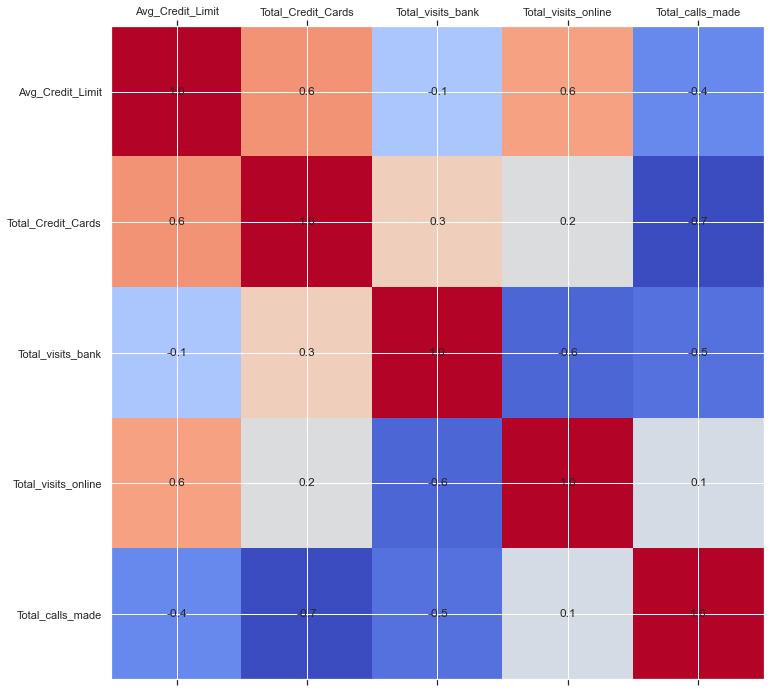

In [21]:
plot_corr(df)

### Comments 
- Total Credit Cards holds shows strong relation with Avg Credit limit, as expected. 
- Credit Limit shows relation with Visits Online, and very weak with Visit Bank

### Building Clustering

### K-means - Elbow curve - Silhouette Score

In [87]:
# Scaling the data set before clustering
scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled=scaler.fit_transform(subset)

In [88]:
#Creating a dataframe from the scaled data above
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

In [90]:
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9429012903926838
Number of Clusters: 7 	Average Distortion: 0.9095950026993534
Number of Clusters: 8 	Average Distortion: 0.8893571274402587
Number of Clusters: 9 	Average Distortion: 0.8658323681013965


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

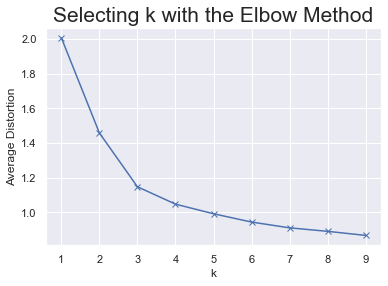

In [25]:
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=21)

### Comments
The appropriate value of k from elbow curve seems to be 3 or 4

### Checking Silhoutte Score

In [26]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41842496663215445)
For n_clusters = 3, silhouette score is 0.5157182558881063)
For n_clusters = 4, silhouette score is 0.3556670619372605)
For n_clusters = 5, silhouette score is 0.2717470361089752)
For n_clusters = 6, silhouette score is 0.25545029453623114)
For n_clusters = 7, silhouette score is 0.2486042710835614)
For n_clusters = 8, silhouette score is 0.2256000814482539)
For n_clusters = 9, silhouette score is 0.21919768667736034)


### Comments

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.
- 1: Means clusters are well apart from each other and clearly distinguished.
- 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
- -1: Means clusters are assigned in the wrong way.

- In our data we can say that the clusters are close from each other as the silhouette score is far to 1.

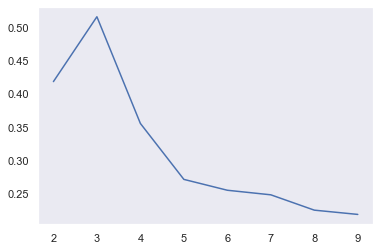

In [27]:
plt.plot(cluster_list,sil_score)
plt.grid()

- From Silhouete score, it seems that 5 is good value of K

In [28]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()

NameError: name 'SilhouetteVisualizer' is not defined

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer

## Due to the issue present installing necessary lybraries. I used another Python in another system to run this specific visualization. Copy of this visualization is in Power Point presentation.

## Comments
- Here is the Silhouette Analysis done on the plot showed in the Power Point: 
    1. The value of n_clusters 5 is not ideal, since the clusters is below-average silhouette scores.
    2. The value of n_cluster 4 also shows below-average and some fluctuations in the size of the silhouette plots
    3. The value of 2 and 3 for n_clusters looks ideal. The silhouette score for each cluster is above average silhouette scores. The fluctuation i size looks the same
    4. For the plot with n_cluster 3, the thickness is more uniform than n_cluster 2. Also in the n_cluster 3 shows thickness more than n_cluster 2.
    - In this case the cluster selected is the 3. 

### Let us take 3 as appropriate no. of clusters as silhoutte score is high enough and there is knick at 5 in elbow curve

In [29]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=0)

In [30]:
df['K_means_segments'] = kmeans.labels_

In [31]:
cluster_profile = df.groupby('K_means_segments').mean()

In [32]:
cluster_profile['count_in_each_segment'] = df.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [33]:
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12300.813008,2.357724,0.878049,3.626016,8.398374,123
1,31226.315789,5.478947,4.515789,1.010526,1.936842,190
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,12019.801980,2.475248,1.000000,3.465347,5.009901,101
4,36260.204082,5.551020,2.494898,0.954082,2.061224,196


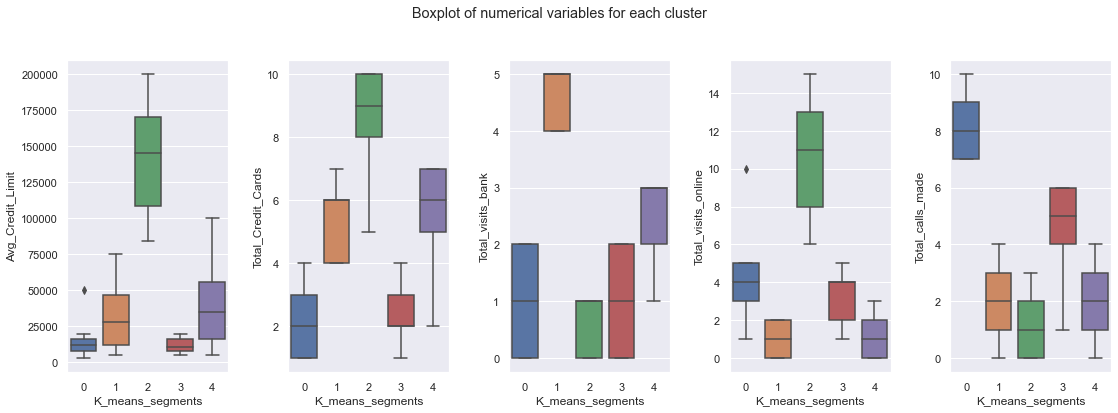

In [34]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

### Comments: 
- Cluster 0: Segment with 123 
    - Credit Limit is average low 12300
    - Total Credit Card low
    - Total Visit bank is low
    - Total Visit online hight
    - Call made hight 
    

- Cluster 1: Segment with 190 
    - Credit Limit average more than 31000
    - Total Credit Card is hight
    - Total Visit bank is hight
    - Total Visit online low
    - Call made low
    
- Cluster 2: Segment with 50
    - Credit Limit average more than 100000
    - Total Credit Card is hight
    - Total Visit bank is low
    - Total Visit online hight
    - Call made low
    
- Cluster 3: Segment with 101
    - Credit Limit average low as 12000
    - Total Credit Card is low
    - Total Visit bank is low
    - Total Visit online medium
    - Call made medium
    
- Cluster 4: Segment with 196
    - Credit Limit average low as 36000
    - Total Credit Card is hight
    - Total Visit bank is low
    - Total Visit online low
    - Call made low

### Business Recommendation

- Cluster 2 is the hight Wealth Customer. Althought thsi group is small, represents a population with highest Credit Limit and often use credit card products. Also this group use often online service. Very possible young population. 
- Cluster 4 consist of 196, and looks that medium financial status. Looks a potential group to invest demanding very low services.
- Cluster 0 hold very low average Credit Limit also are not a group that hold great amount of credit cards. This group use online service often.
- Visit bank is low in most of the Cluster.
- Visits online looks like is growing. Investments on this service can be good idea.
- Suggest Clusters 2 and 4 to market in the future

### Hierarchical clustering

In [77]:
# Scaling the data set before clustering
scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled_df=scaler.fit_transform(subset)

In [78]:
subset_scaled_df

array([[ 1.74018685, -1.24922476, -0.86045063, -0.54748969, -1.25153737],
       [ 0.41029254, -0.78758515, -1.47373077,  2.5205186 ,  1.89185881],
       [ 0.41029254,  1.05897329, -0.86045063,  0.13428993,  0.1455276 ],
       ...,
       [ 2.93709172,  1.5206129 , -0.86045063,  2.17962879, -0.90227113],
       [ 3.65523464,  2.44389211, -0.86045063,  4.22496765, -1.25153737],
       [ 3.52224521,  1.9822525 , -1.47373077,  3.20229822, -0.55300488]])

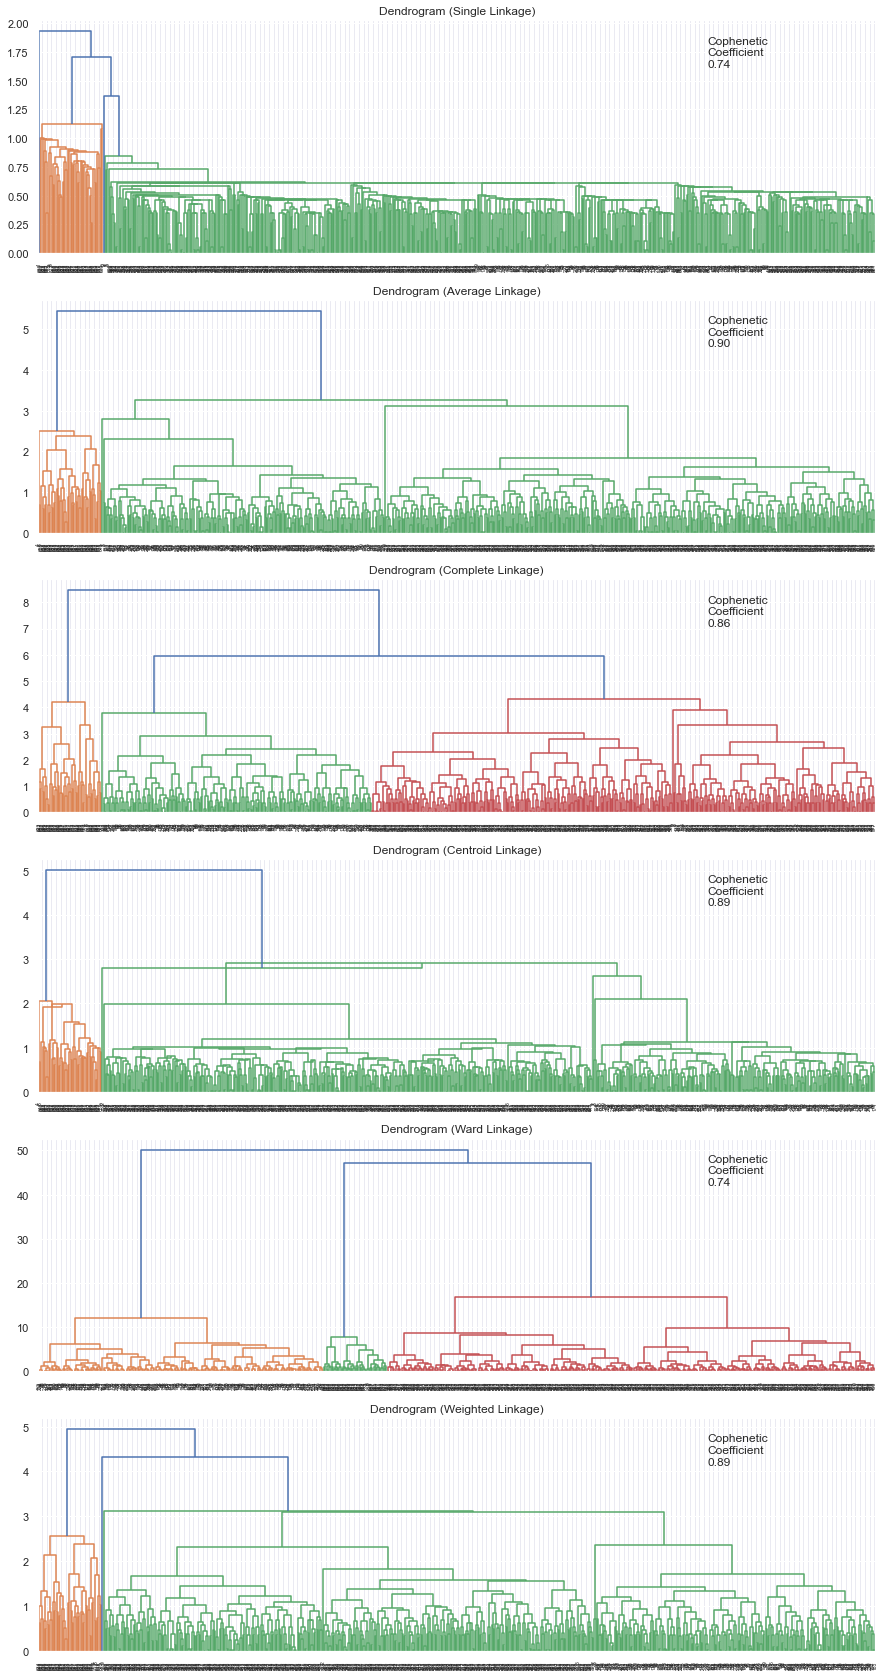

In [79]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
# compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
#     compare.append([method, coph_corr])

### Comments 
- The Dendogram Ward Linkage showing separate and distinct clusters
- 5 cluster would be appropriate number of cluster from dendrogram with ward linkage.

## Building 5 clusters

In [91]:
#Trying with K value as 5
HCmodel = AgglomerativeClustering(n_clusters=5,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df)
subset_scaled_df['HC_Clusters'] = HCmodel.labels_

In [92]:
df['HC_Clusters'] = HCmodel.labels_

In [94]:
#df.drop(['K_means_segments'],axis=1,inplace=True)

In [95]:
cluster_profile = df.groupby('HC_Clusters').mean()

In [96]:
cluster_profile['count_in_each_segments'] = df.groupby('HC_Clusters')['Avg_Credit_Limit'].count().values

In [97]:
# lets see Key IDs of each customer in each cluster
for cl in df['HC_Clusters'].unique():
    print('In cluster ', cl ,' clutries are: ')
    print(df[df['HC_Clusters']==cl]['Customer_Key'].unique())

In cluster  0  clutries are: 
[87073, 17341, 40496, 54838, 35254, ..., 85234, 31948, 90191, 11562, 16253]
Length: 191
Categories (191, int64): [87073, 17341, 40496, 54838, ..., 31948, 90191, 11562, 16253]
In cluster  4  clutries are: 
[38414, 92503, 55196, 87241, 24001, ..., 79632, 72892, 51773, 96163, 55849]
Length: 92
Categories (92, int64): [38414, 92503, 55196, 87241, ..., 72892, 51773, 96163, 55849]
In cluster  2  clutries are: 
[47437, 48370, 94391, 50598, 40019, ..., 51108, 60732, 53834, 80655, 80150]
Length: 50
Categories (50, int64): [47437, 48370, 94391, 50598, ..., 60732, 53834, 80655, 80150]
In cluster  3  clutries are: 
[58634, 37376, 82490, 44770, 52741, ..., 73811, 61234, 56156, 49331, 72156]
Length: 133
Categories (133, int64): [58634, 37376, 82490, 44770, ..., 61234, 56156, 49331, 72156]
In cluster  1  clutries are: 
[46635, 83125, 15129, 83290, 56486, ..., 99284, 47198, 67415, 49341, 80623]
Length: 193
Categories (193, int64): [46635, 83125, 15129, 83290, ..., 47198, 

> Cluster 0: 191 |
> Cluster 4: 92 |
> Cluster 2: 50 |
> Cluster 3: 133 |
> Cluster 1: 193 |

In [98]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,38298.429319,5.670157,2.523560,0.947644,2.099476,191
1,29474.226804,5.365979,4.448454,1.010309,1.891753,194
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,11834.586466,2.631579,0.977444,3.338346,5.556391,133
4,12608.695652,2.119565,0.880435,3.847826,8.739130,92


IndexError: list index out of range

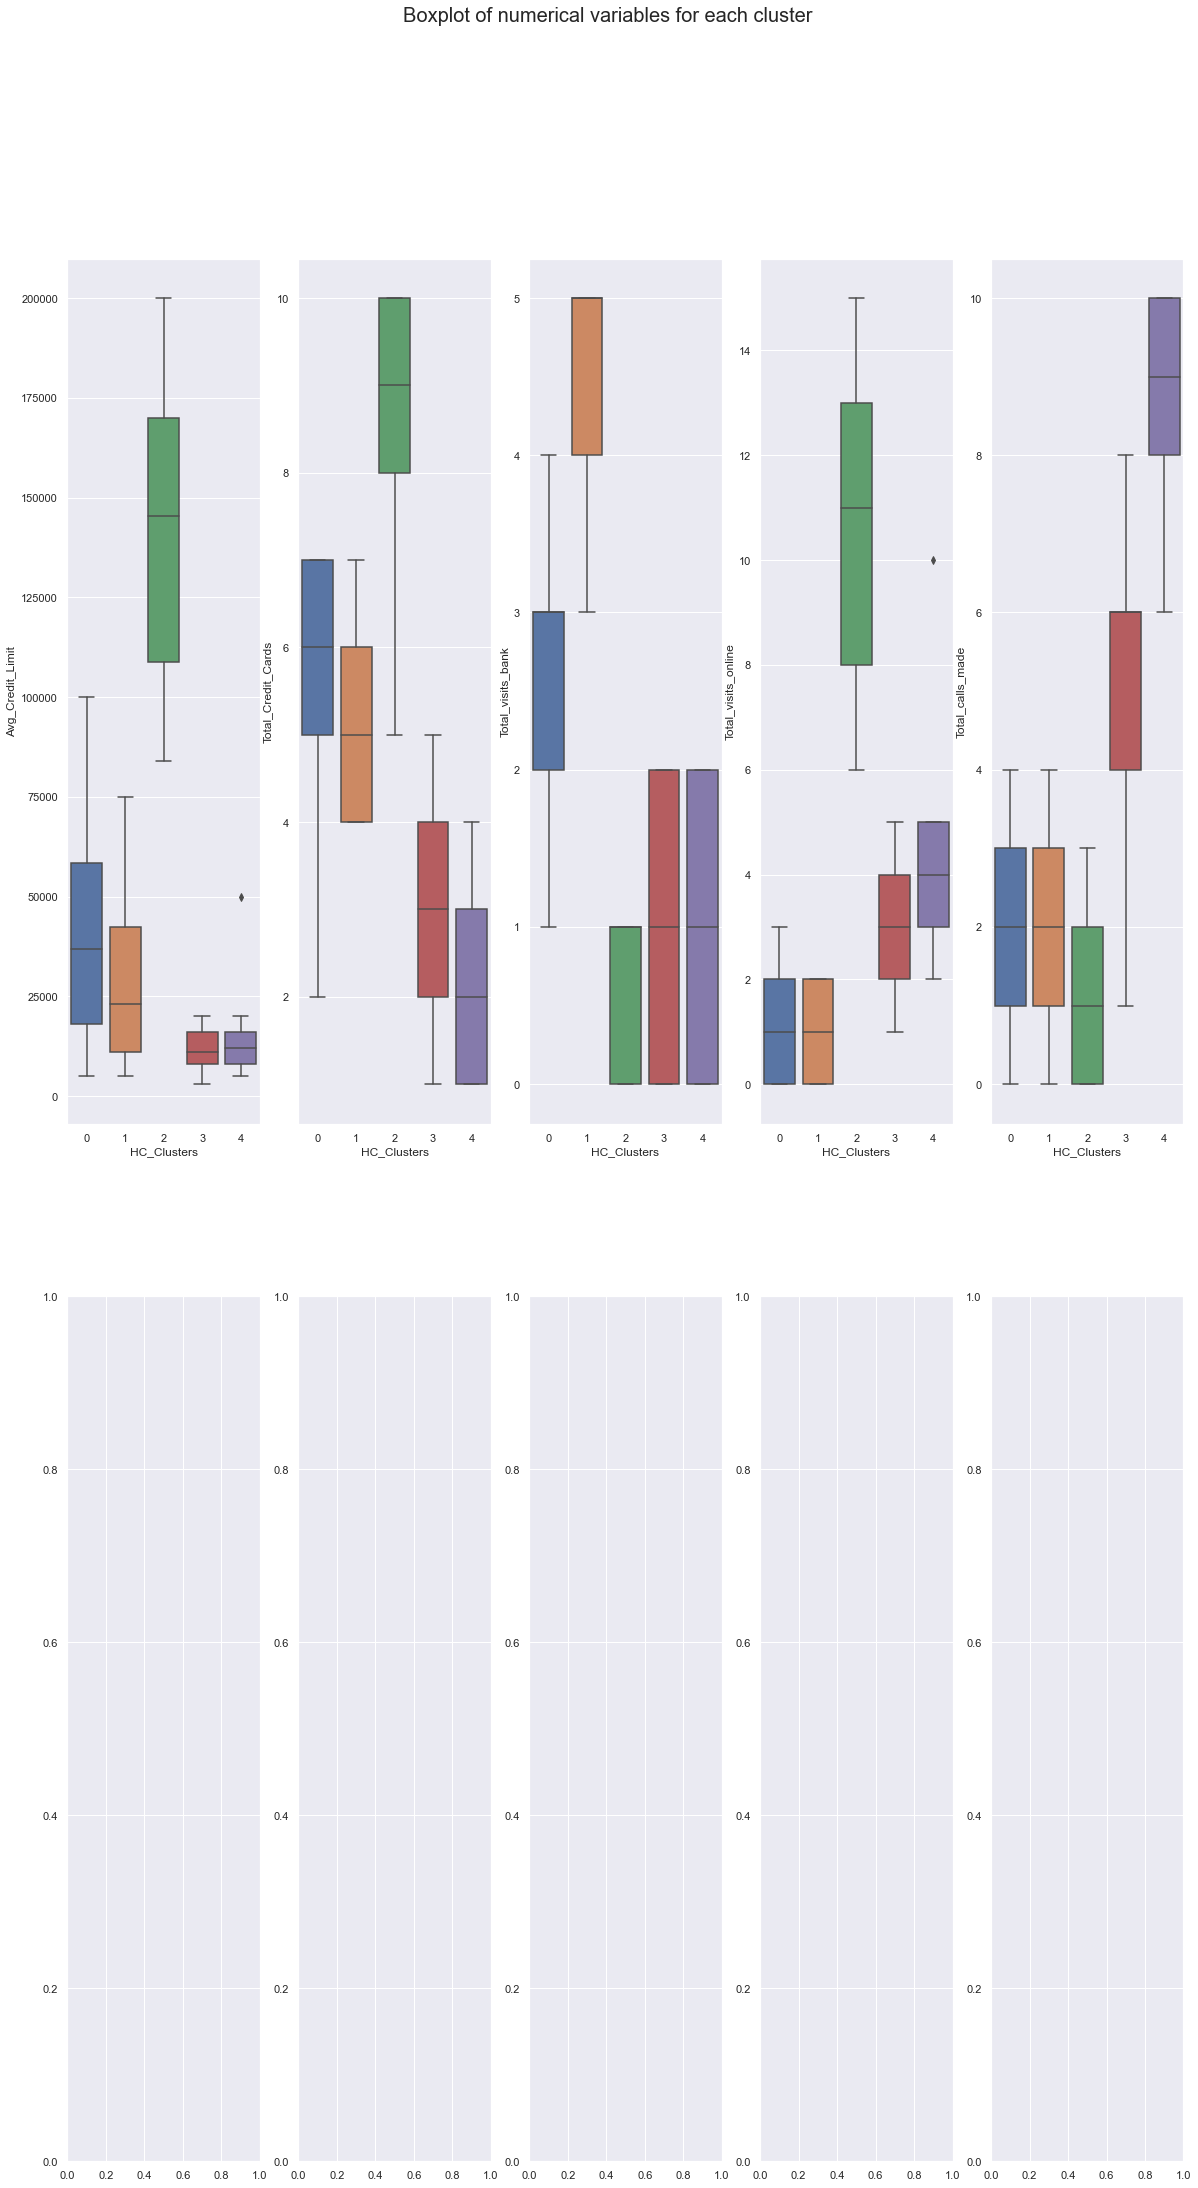

In [100]:
# data frame : df
fig, axes = plt.subplots(2,5 ,  figsize=(20, 35))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii][0],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][1],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][2],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][3],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][4],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1

    
fig.tight_layout(pad=2.0)

### Comments:
-- Cluster 0: Segment with 191 customer Keys
- Credit Limit is average is medium with 38298.42
- Total Credit Card is medium
- Total Visit bank is low
- Total Visit online is low
- Call made high low

-- Cluster 1: Segment with 194 customer Keys
- Credit Limit average more than 29474.22
- Total Credit Card is medium
- Total Visit bank is medium
- Total Visit online low
- Call made low

-- Cluster 2: Segment with 50 customer Keys
- Credit Limit average more than 100000
- Total Credit Card is hight
- Total Visit bank is low
- Total Visit online high
- Call made low

-- Cluster 3: Segment with 133 customer Keys
- Credit Limit average low
- Total Credit Card is low
- Total Visit bank is low
- Total Visit online low
- Call made low

-- Cluster 4: Segment with 92 customer Keys
- Credit Limit average low
- Total Credit Card is low
- Total Visit bank is low
- Total Visit online medium
- Call made high

### Recommendation
- Cluster 2 (group of Clients IDs - Keys) and Cluster 0 are good population to target by market campaign based on cluster profiling done above. Because these are the groups that have the greatest financial resources, use the banking service and demand less attention.
- Cluster is the medium financial status. Looks a potential group to invest demanding medium attention of services.
- Cluster 4 hold very low average Credit Limit also are not a group that hold great amount of credit cards. This group use call center service often

### Apply PCA - Reducing the number of variables

In [101]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(subset_scaled_df2)

PCA()

In [102]:
# Show variance explained by individual components
pca.explained_variance_ratio_

array([0.45736578, 0.37426483, 0.06401348, 0.0555688 , 0.04878711])

Text(0, 0.5, 'Cumulative Explained Variance')

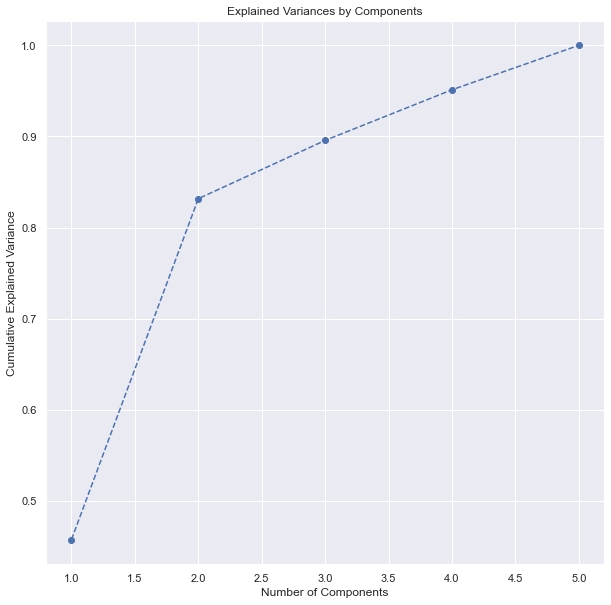

In [103]:
# visulaize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

### Comments 
- for 95% variance , the number of components should be 4

In [104]:
pca = PCA(.95,svd_solver ='full') # svd_solver -full helps to converge faster in case of very large data set
pca.fit(subset_scaled_df2)

PCA(n_components=0.95, svd_solver='full')

In [105]:
pca.explained_variance_

array([2.29029906, 1.87416377, 0.3205531 , 0.27826563])

Text(0, 0.5, 'Cumulative Explained Variance')

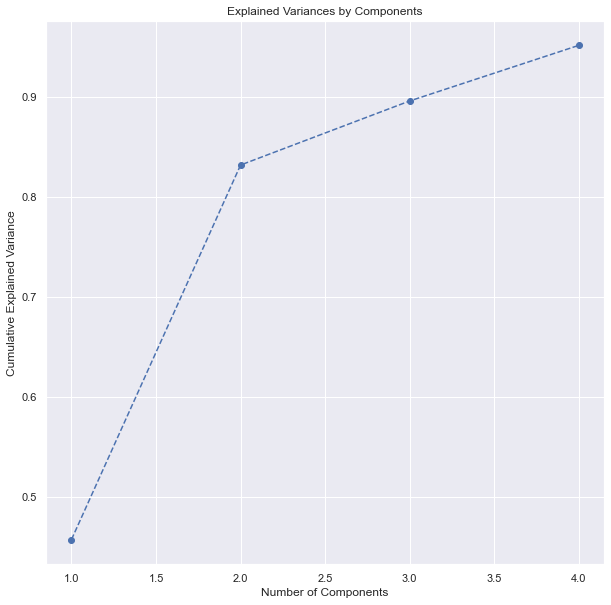

In [106]:
plt.figure(figsize = (10,10))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [107]:
subset_pca = pca.transform(subset_scaled_df2)
subset_pca = pd.DataFrame(subset_pca)

### Perform Clustering on PCA

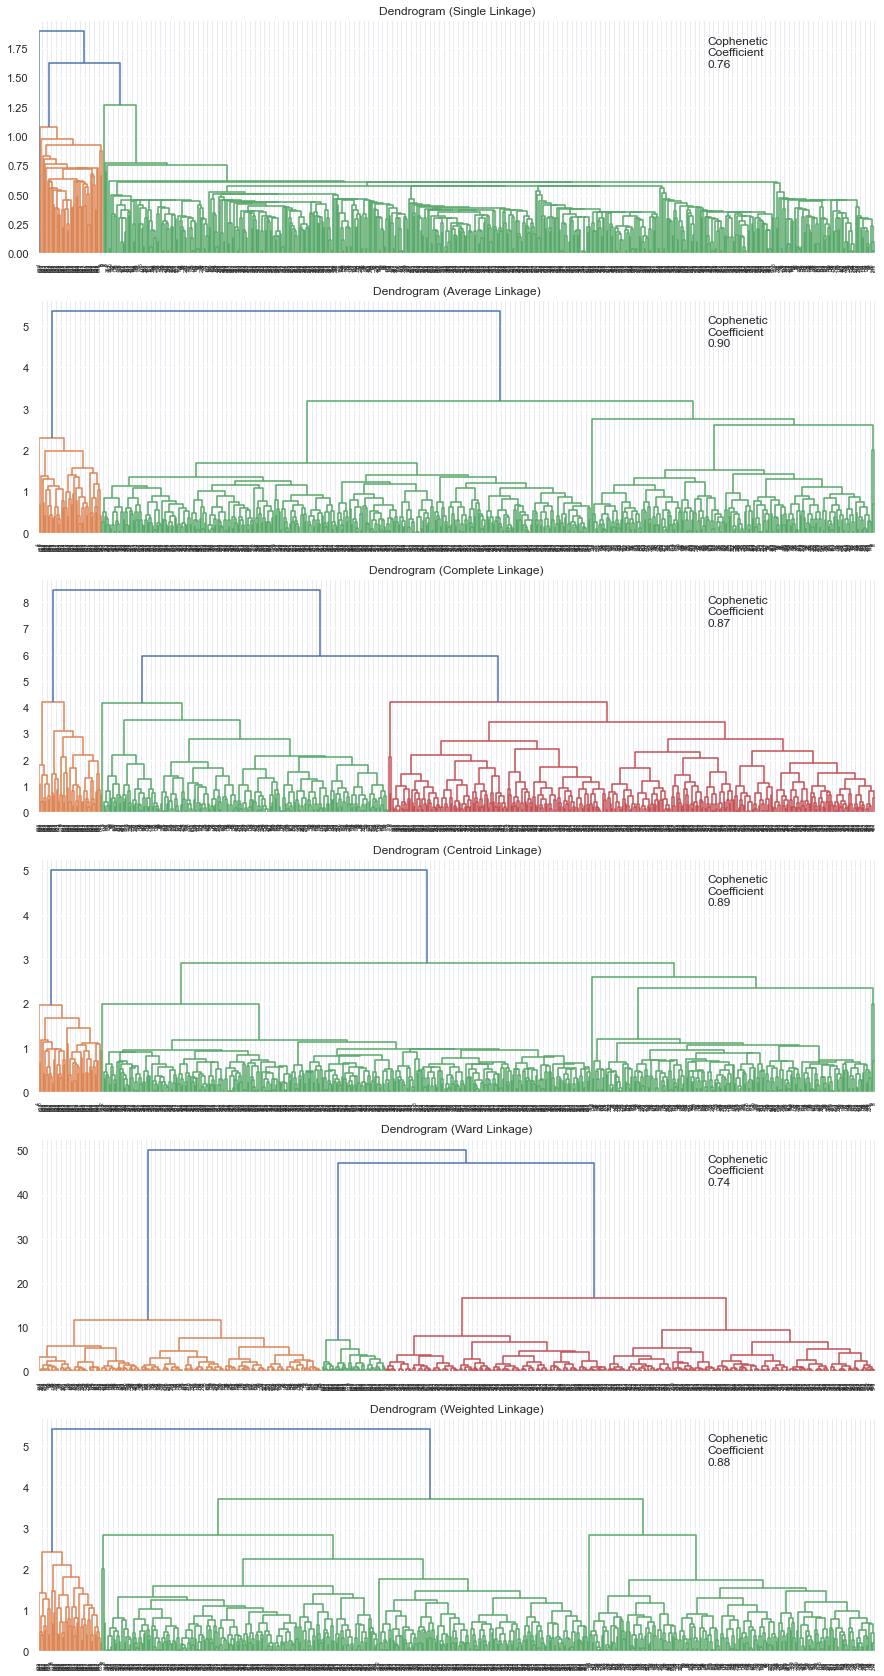

In [69]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
# compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_pca, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df2))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
#     compare.append([method, coph_corr])

### Comments¶
- The Dendogram Ward Linkage showing separate and distinct clusters
- 5 cluster would be appropriate number of cluster from dendrogram with ward linkage.

In [108]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
hc_labels = hc.fit_predict(subset_pca)

In [109]:
dff = df.drop(['HC_Clusters'] ,axis=1)

In [110]:
dff['PCA_HC_clusters'] = hc_labels

In [111]:
cluster_profile2 = dff.groupby('PCA_HC_clusters').mean()
cluster_profile2['count_in_each_segments'] = dff.groupby('PCA_HC_clusters')['Avg_Credit_Limit'].count().values

In [112]:
# lets see names of countries in each cluster
for cl in dff['PCA_HC_clusters'].unique():
    print('In cluster ', cl ,' clutries are: ')
    print(df[dff['PCA_HC_clusters']==cl]['Customer_Key'].unique())

In cluster  0  clutries are: 
[87073, 17341, 54838, 35254, 97825, ..., 85234, 31948, 90191, 11562, 16253]
Length: 211
Categories (211, int64): [87073, 17341, 54838, 35254, ..., 31948, 90191, 11562, 16253]
In cluster  4  clutries are: 
[38414, 92503, 55196, 24001, 68067, ..., 72892, 51773, 96163, 55849, 56156]
Length: 81
Categories (81, int64): [38414, 92503, 55196, 24001, ..., 51773, 96163, 55849, 56156]
In cluster  3  clutries are: 
[40496, 58634, 37376, 82490, 44770, ..., 54477, 12122, 28208, 73811, 61234]
Length: 143
Categories (143, int64): [40496, 58634, 37376, 82490, ..., 12122, 28208, 73811, 61234]
In cluster  2  clutries are: 
[47437, 48370, 94391, 50598, 40019, ..., 51108, 60732, 53834, 80655, 80150]
Length: 50
Categories (50, int64): [47437, 48370, 94391, 50598, ..., 60732, 53834, 80655, 80150]
In cluster  1  clutries are: 
[46635, 83125, 15129, 83290, 56486, ..., 99284, 47198, 67415, 49341, 80623]
Length: 174
Categories (174, int64): [46635, 83125, 15129, 83290, ..., 47198, 

In [113]:
# lets display cluster profile
cluster_profile2.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
PCA_HC_clusters,,,,,,
0,35165.876777,5.601896,2.606635,0.985782,2.161137,211
1,31982.857143,5.405714,4.560000,0.982857,1.805714,175
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,12195.804196,2.496503,0.902098,3.321678,5.671329,143
4,12419.753086,2.271605,0.975309,3.950617,8.987654,81


IndexError: list index out of range

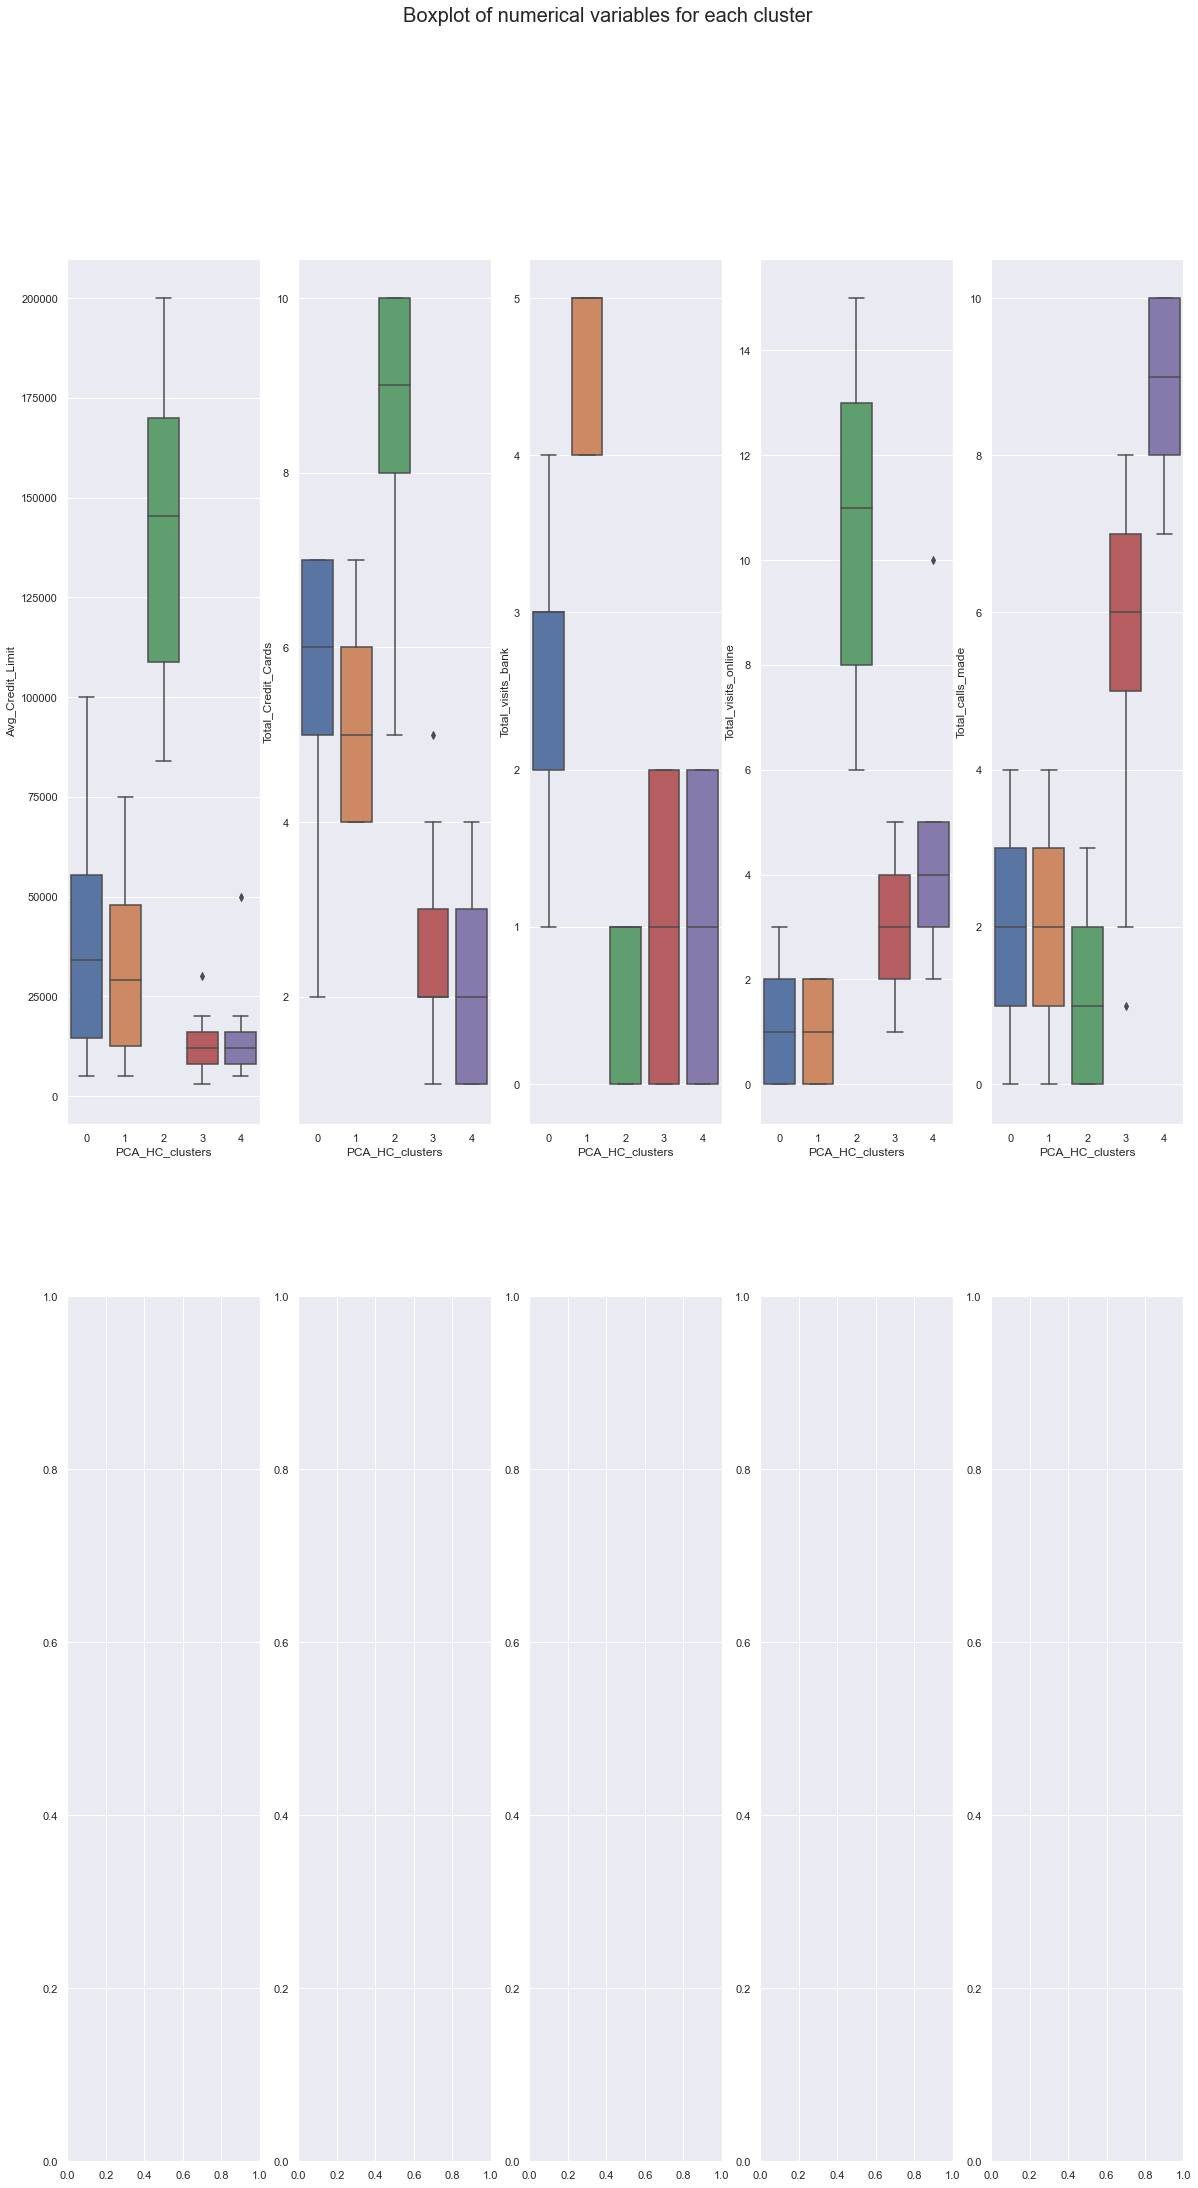

In [76]:
fig, axes = plt.subplots(2, 5,  figsize=(20, 35))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii][0],y=dff[all_col[counter]],x=dff['PCA_HC_clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][1],y=dff[all_col[counter]],x=dff['PCA_HC_clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][2],y=dff[all_col[counter]],x=dff['PCA_HC_clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][3],y=dff[all_col[counter]],x=dff['PCA_HC_clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][4],y=dff[all_col[counter]],x=dff['PCA_HC_clusters'])
    counter = counter+1

    counter = counter+1
fig.tight_layout(pad=2.0)


### Comments:
-- Cluster 0: Segment with 211 customer Keys
- Credit Limit is average above 35000
- Total Credit Card is medium
- Total Visit bank is low
- Total Visit online is low
- Call made high low

-- Cluster 1: Segment with 175 customer Keys
- Credit Limit average more than 31000
- Total Credit Card is medium
- Total Visit bank is medium
- Total Visit online low
- Call made low

-- Cluster 2: Segment with 50 customer Keys
- Credit Limit average more than 141000
- Total Credit Card is hight
- Total Visit bank is low
- Total Visit online high
- Call made low

-- Cluster 3: Segment with 143 customer Keys
- Credit Limit average little more than 12000
- Total Credit Card is low
- Total Visit bank is low
- Total Visit online low
- Call made medium

-- Cluster 4: Segment with 81 customer Keys
- Credit Limit average little more than 12000
- Total Credit Card is low
- Total Visit bank is low
- Total Visit online low
- Call made high